# Neural Networks - A Practical Introduction
by _Minho Menezes_  

---

## Multilayer Perceptron for Computer Vision



---

### Libraries

In [1]:
## LIBRARIES ##
import numpy as np                         # Library for Numerical and Matricial Operations
import matplotlib.pyplot as plt            # Library for Generating Visualizations
import pandas as pd                        # Library for Handling Datasets
from tools import Tools as tl              # Library for some Utilitary Tools
from glob import glob                      # Library for File Searching

# Function for loading the MNIST dataset into a Numpy Matrix
import pickle

def loadMNIST():
    with open("../data/mnist/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"].T, mnist["test_images"].T, mnist["training_labels"].T, mnist["test_labels"].T

### The Neural Networks Class

In [2]:
## CLASS: Multilayer Perceptron ##
class MultilayerPerceptron:
    
    # CLASS CONSTRUCTOR
    def __init__(self, n_neurons=[2, 5, 1]):
        if(len(n_neurons) < 2):
            raise ValueError("The network must have at least two layers! (The input and the output layers)")
        
        # Network Architecture
        self.hidden_layers = len(n_neurons)-2
        self.n_neurons = n_neurons
        self.W = []
        
        # Adjusting the Network architecture
        for i in range(1, len(n_neurons)):
            self.W.append( np.random.randn(self.n_neurons[i-1]+1 , self.n_neurons[i]) )
        
    # ACTIVATION FUNCTION
    def activate(self,Z):
        return 1 / (1 + np.exp(-Z))
    
    # FORWARD PROPAGATION
    def forward(self, X):
        # Activation List
        A = []
        
        # Input Layer Activation
        A.append( np.vstack([np.ones([1, X.shape[1]]), X]) )
        
        # Hidden Layer Activation
        for i in range(0, self.hidden_layers):
            Z = np.matmul(self.W[i].T, A[-1])
            Z = self.activate(Z)
            
            A.append( np.vstack([np.ones([1, Z.shape[1]]), Z]) )
        
        # Output Layer Activation
        Z = np.matmul(self.W[-1].T, A[-1])
        Z = self.activate(Z)

        A.append(Z)
        
        return A
    
    # CLASSIFICATION PREDICTION
    def predict(self, X):
        A = self.forward(X)
        
        if(self.n_neurons[-1] > 1):
            return A[-1].argmax(axis=0)
        else:
            return (A[-1] > 0.5).astype(int)
    
    # LOSS FUNCTION
    def loss(self, y, y_hat):
        m = y.shape[1]
        return -(1/m) * np.sum(y * np.log(y_hat) + (1-y) * np.log(1 - y_hat))
    
    # ACCURACY FUNCTION
    def accuracy(self, y, y_hat):
        m = y.shape[1]
        return (1/m) * np.sum(y == y_hat) * 100
    
    # BACKPROPAGATION
    def backpropagate(self, A, y):
        # Calculates the error in the Output Layer (difference between the real and the predicted)
        E = []
        E.append( A[-1] - y )

        # Backpropagates the error to all the Hidden Layers
        for i in range(self.hidden_layers, 0, -1):
            E.append( np.matmul(self.W[i], E[-1]) * A[i] * (1-A[i]) )
            E[-1] = E[-1][1:,:]

        # Returns the list of Error Matrices
        return E[::-1]
    
    # GRADIENT DESCENT TRAINING
    def train(self, X_train, y_train, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=True):
        # Returns the total number of samples in the training
        m = X_train.shape[1]

        # Defines the Error History and other auxiliary variables
        errorHist = []

        # Gradient Descent Loop
        for it in range(0, maxIt):
            # 1. Calculates all the activations and prediction (Forward Propagation) and 
            #    the errors (Backpropagation), using the current weights self.Wˆ(i)
            A = self.forward(X_train)
            E = self.backpropagate(A, y_train)
            P = self.predict(X_train)

            # 2. Calculates the Evaluation Metrics
            actualLoss = self.loss(y_train, A[-1])
            actualAcc = self.accuracy(y_train, P)
            errorHist.append(actualLoss)

            # 3. Updates the Neural Networks weights
            for i in range(0, self.hidden_layers+1):
                self.W[i] = self.W[i] - (alpha/m) * np.matmul(A[i], E[i].T)

            # 4. Prints the training results
            if(verbose): 
                print("# Iteration {0:5} -> Loss: {1:} \t| Accuracy: {2:.3f}".format(it+1, actualLoss, actualAcc))

            # 5. Check for convergence and prints the final result for the training.
            if(it > 1 and abs(errorHist[-1] - errorHist[-2]) <= tol):
                print("\n!!! Convergence reached !!!")
                print("# Iteration", it, "#")
                print("Cross-Entropy Loss:      {}".format(actualLoss))
                print("Accuracy (Training Set): {0:.3f}%".format(actualAcc))
                print("Weights\nS -> H:\n", self.W[0], "\nH -> O:\n", self.W[1])
                print("\n")
                break;

        # End of the Training
        return errorHist
        
## ---------------------------- ##

---

### 1. Image Data Extraction

When working with Computer Vision, the first thing you need, of course, is to be able to open image data and format it to some shape that your Neural Network can understand. This is a step in this field known as **Feature Extraction**. Consider the case of the following image:

<img src="../data/mnist/mnist1.png" alt="binary multilayer perceptron" width="100px"/>

There are, mainly, two ways that we can feed this image to a Neural Network:

1. We can extract, in advance, some informations that descripts the image (mean of colors, borders positions, center of mass, etc.) and build a vector comprising these descriptions. This vector is then used as a Input Layer to the Neural Network.

2. The entire image (28x28 pixels, in this case) is arranged into a vector shape. This vector (that will have dimension 784x1) is then used as a Input Layer to the Neural Network.

Of course, in the first case it is possible that we form a set of features that is much smaller than 784 (in the second case), hence performing faster. However, this process can be time-consuming and maybe some information will still be missing. The second case requires more memory and processing power, but usually yields a better performance. We will stick to the second approach, now, because this are actually one of the reasons that Neural Networks are popular right now.

**To build your own dataset from image data, first use the function _plt.imread()_ to capture the matrices of a image and the function _plt.imshow()_ to visualize it:**

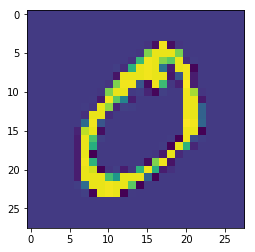

In [3]:
# Open an image and returns the pixel matrices
X = plt.imread("../data/mnist/mnist1.png")

# Selects only the pixel intensity for one of the RGBA channels
X = X[:,:,0]

# Exhibits the image loaded in such matrix
plt.figure()
plt.imshow(X)
plt.show()

To flatten the entire image to an array of specific dimensions, we use the method _.reshape()_ from the Numpy matrices. 

In [4]:
# Flatten the image to a column vector
X = X.reshape(-1, 1)

print("Dimensions of X:", X.shape)

Dimensions of X: (784, 1)


This is only one image. In order to built an entire dataset, we need to iteratively load and reshape all the images that we have in our database:

In [5]:
# Returns the name of all PNG files in the MNIST folder
filenames = glob("../data/mnist/*.png")

# Creates the dataset by horizontally stacking the individual images
X = np.zeros([28*28, len(filenames)])
for i,f in enumerate(filenames):
    img = plt.imread(f)
    img = img[:,:,0]
    X[:,i] = img.reshape(1,-1)
    
# Prints part of the dataset
print("Dataset:\n", X)
print("\nDimensions:", X.shape)

Dataset:
 [[0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 ...
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]]

Dimensions: (784, 9)


Finally, we need to indicate the real class of each image. This work is usually done manually to label each image by actually looking at it.

In this case, we first visualize each example of our dataset:

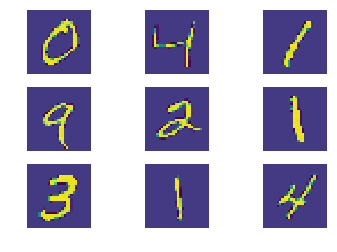

In [6]:
# Exhibits the images in the dataset
plt.figure()
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,j + 3*i +1)
        plt.imshow(X[:,j + 3*i].reshape(28,28))
        plt.axis('off')

plt.show()

Then, we manually create the labels vector $Y$:

In [7]:
# Defines the label classes:
y = np.array(["0", "4", "1", "9", "2", "1", "3", "1", "4"])

### 2. Loading the MNIST Dataset

You could be worried if a dataset with only 9 samples is enough to train a Neural Network. You are right.

The number of samples needed to train a Neural Network varies from the problem and the architecture of the network. The intention is to get as much data as possible, but they also must have great variance to expose the network to several possible cases. In the Computer Vision case, however, the number of input is too great, and the Networks tends to be proportionally as big. In this case we need very big datasets.

The **[MNIST dataset](http://yann.lecun.com/exdb/mnist/)** is a very popular dataset of 70,000 images of handwritten digits that are used as benchmark data for several machine learning models. Actually the images that you used before are samples of this dataset.

**We will then, work with this data:**

In [8]:
# Loads the entire MNIST dataset
X_train, X_test, y_train, y_test = loadMNIST()

We can also visualize samples from this dataset by using the _.reshape()_ and the _plt.imshow()_ functions:

Labels:

	7	5	0	0	7	
	9	5	1	8	7	
	5	0	4	6	6	

Images:


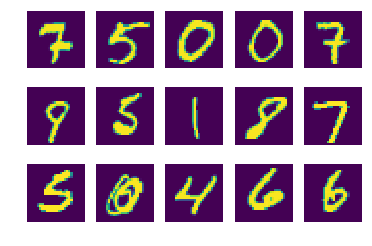

In [9]:
# Exhibits the images in the dataset
print("Labels:")

plt.figure()
for i in range(0,3):
    print(end="\n\t")
    for j in range(0,5):
        plt.subplot(3,5,j + 5*i +1)
        
        # Selects a random example from the dataset
        idx = np.random.randint(0, 60000)
        print(y_train[idx], end="\t")
        plt.imshow(X_train[:,idx].reshape(28,28))
        
        plt.axis('off')


print("\n\nImages:")
plt.show()

### 3. Training the Network

### 4. Testing the Network

----